Here we attempt to show that the jackknife errors converge as the number of jackknives increase (now that we fixed the issue with the prior on shear).

In [54]:
import os
os.environ["JAX_ENABLE_X64"] = "True"


In [55]:
from tqdm import tqdm 

In [56]:
from functools import partial

import bpd

from jax import jit, vmap

import jax.numpy as jnp

from bpd.sample import sample_noisy_ellipticities_unclipped
from bpd.pipelines import logtarget_toy_ellips, pipeline_shear_inference_simple

from bpd.chains import run_inference_nuts

from jax import random

import matplotlib.pyplot as plt 

import numpy as np 


In [57]:
seed = 99
g1 = 0.02 
g2 = 0.0

shape_noise = 0.02
sigma_e_int=0.05
sigma_m = 1e-5

In [58]:
# sample ellipticities

k = random.key(seed)
k1, k2, k3, k4 = random.split(k, 4 )
true_g = jnp.array([g1, g2])

In [78]:
e_obs_p, _, e_int = sample_noisy_ellipticities_unclipped(
    k1, g=true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=100 * 10
)

e_obs_m, _, _ = sample_noisy_ellipticities_unclipped(
    k1, g=(-1) * true_g, sigma_m=sigma_m, sigma_e=shape_noise, n=100 * 10
)

In [79]:
e_obs_p.shape, e_obs_m.shape

((1000, 2), (1000, 2))

In [80]:
def get_e1e2_post(key, e_obs_plus, e_obs_minus, *, sigma_e_int, sigma_m, n_samples=300):

    _logtarget = partial(logtarget_toy_ellips, sigma_m=sigma_m, sigma_e_int=sigma_e_int)

    k2s = random.split(key, e_obs_plus.shape[0])

    _pipe = jit(
        partial(
            run_inference_nuts,
            logtarget=_logtarget,
            n_samples=n_samples,
            initial_step_size=0.01,
            max_num_doublings=2,
            n_warmup_steps=500,
        )
    )
    pipe = vmap(_pipe, in_axes=(0, 0, 0))

    _ = pipe(k2s[:2], e_obs_plus[:2], e_int[:2])
    
    e1e2p = pipe(k2s, e_obs_plus, e_int)
    e1e2m = pipe(k2s, e_obs_minus, e_int)

    return e1e2p, e1e2m

In [81]:
# now  obtain posteriors 
e1e2p, e1e2m = get_e1e2_post(k2, e_obs_p, e_obs_m, sigma_e_int=sigma_e_int, sigma_m=sigma_m)

In [82]:
e1e2p.shape, e1e2m.shape

((1000, 300, 2), (1000, 300, 2))

In [83]:
def get_shear(key, e1e2, *, shape_noise, sigma_e_int, n_samples:int=1000):
    
    raw_pipeline = partial(
        pipeline_shear_inference_simple,
        init_g=jnp.array([0.0, 0.0]),
        sigma_e=shape_noise ,
        sigma_e_int=sigma_e_int,
        n_samples=n_samples,
        initial_step_size=0.01,
    )
    pipe = jit(raw_pipeline)


    return pipe(key, e1e2)

In [84]:
gp = get_shear(k3, e1e2p, shape_noise=shape_noise , sigma_e_int=sigma_e_int)
gp.shape

(1000, 2)

In [85]:
gm = get_shear(k3, e1e2m, shape_noise=shape_noise , sigma_e_int=sigma_e_int)
gm.shape

(1000, 2)

In [86]:
m = (gp[:, 0].mean() - gm[:, 0].mean()) / 2/ 0.02 -1
m

Array(-6.54415011e-05, dtype=float64)

# Jackknife errors

In [87]:
n_gals = e1e2p.shape[0]
n_gals

1000

In [88]:
_pipe = jit(partial(get_shear, shape_noise=shape_noise, sigma_e_int=sigma_e_int))

In [89]:
e1e2p.shape

(1000, 300, 2)

In [90]:
n_jacks = 100


b1 = n_gals // n_jacks
assert n_jacks * b1 == n_gals
k3s = random.split(k3, n_jacks)

e1e2pj = [] 
e1e2mj = [] 
for ii in range(n_jacks):
    start, end = ii * b1, (ii + 1) * b1
    e1e2pj.append(jnp.concatenate([e1e2p[:start], e1e2p[end:]]))
    e1e2mj.append(jnp.concatenate([e1e2m[:start], e1e2m[end:]]))

e1e2pj = jnp.stack(e1e2pj, axis=0)
e1e2mj = jnp.stack(e1e2mj, axis=0)

        


In [91]:
e1e2pj.shape

(100, 990, 300, 2)

In [92]:
gpj = vmap(_pipe, in_axes=(None, 0))(k3, e1e2pj)

In [93]:
gpj.shape

(100, 1000, 2)

In [94]:
gmj = vmap(_pipe, in_axes=(None, 0))(k3, e1e2mj)

In [95]:
gmj.shape

(100, 1000, 2)

In [96]:
mj = (gpj[:, :, 0].mean(1) - gmj[:, :, 0].mean(1)) / 2 / 0.02  - 1
mj.shape

(100,)

In [97]:
mj.std()

Array(0.00018015, dtype=float64)

In [98]:
gpj[:, :, 0].mean(), gp[:, 0].mean(), 

(Array(0.02033819, dtype=float64), Array(0.02033842, dtype=float64))

In [99]:
gmj[:, :, 0].mean(), gm[:, 0].mean(), 

(Array(-0.01966195, dtype=float64), Array(-0.01965897, dtype=float64))

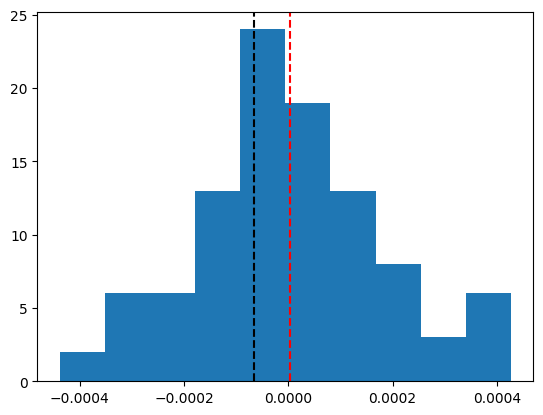

In [100]:
plt.hist(mj)
plt.axvline(m, c='k', ls='--')
plt.axvline(mj.mean(), c='r', ls='--')

In [101]:
m, mj.mean(), np.sqrt(mj.var() * (len(mj) - 1))

(Array(-6.54415011e-05, dtype=float64),
 Array(3.37761552e-06, dtype=float64),
 np.float64(0.0017924888046422028))

## Jackknife convergence

In [152]:
n_jackss = (10, 50, 100, 200)
mjs = [] 

for n_jacks in tqdm(n_jackss):
    b1 = n_gals // n_jacks
    k3s = random.split(k3, n_jacks)

    e1e2pj = [] 
    e1e2mj = [] 
    for ii in range(n_jacks):
        start, end = ii * b1, (ii + 1) * b1
        e1e2pj.append(jnp.concatenate([e1e2p[:start], e1e2p[end:]]))
        e1e2mj.append(jnp.concatenate([e1e2m[:start], e1e2m[end:]]))

    e1e2pj = jnp.stack(e1e2pj, axis=0)
    e1e2mj = jnp.stack(e1e2mj, axis=0)

    gpj = vmap(_pipe)(k3s, e1e2pj)
    gmj = vmap(_pipe)(k3s, e1e2mj)
    mj = (gpj[:, :, 0].mean(1) - gmj[:, :, 0].mean(1)) / 2/ 0.02  - 1
    mjs.append(mj)

2025-04-11 10:08:13.999147: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.97GiB (rounded to 20371523328)requested by op 
2025-04-11 10:08:13.999429: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ****___***_________________********_______*********_________________________________________________
E0411 10:08:13.999451 1272324 pjrt_stream_executor_client.cc:3086] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20371523176 bytes.
 80%|████████  | 4/5 [08:42<02:10, 130.61s/it]


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20371523176 bytes.

In [153]:
len(mjs)

4

In [177]:
mj_means  = [mj.mean() for mj in mjs]
mj_sigmas = [np.sqrt(mj.var() * (len(mj) - 1)) for mj in mjs]

In [181]:
len(mjs[0])

10

In [183]:
# explicit expression
[ np.sqrt((len(mj) - 1) / len(mj) * np.sum( (mj - mj.mean())**2 ) ) for mj in mjs]

[np.float64(0.0009992877813459233),
 np.float64(0.0020501438904605746),
 np.float64(0.003166261437133035),
 np.float64(0.0033813438725487925)]

In [178]:
mj_means, mj_sigmas

([Array(-0.00012086, dtype=float64),
  Array(-4.64712922e-05, dtype=float64),
  Array(1.00987258e-05, dtype=float64),
  Array(2.88625318e-05, dtype=float64)],
 [np.float64(0.0009992877813459233),
  np.float64(0.002050143890460574),
  np.float64(0.003166261437133035),
  np.float64(0.0033813438725487925)])

Array(0.0002397, dtype=float64)

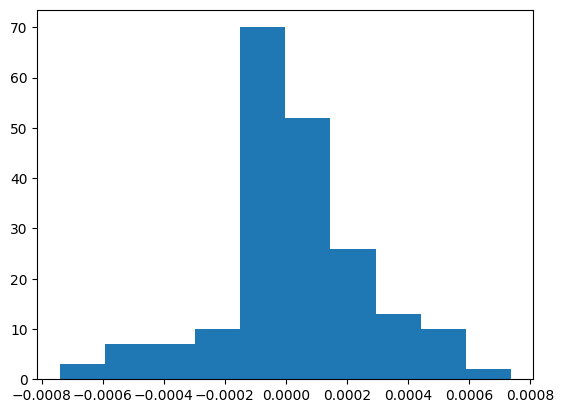

In [180]:
plt.hist(mjs[-1])
mjs[-1].std()

# Bootstrap comparison

In [102]:
n_boots = 200

In [103]:
k3s = random.split(k3, n_boots)

In [104]:
indices = random.choice(k4, jnp.arange(len(e1e2p)), shape=(n_boots, 1000), replace=True)

In [105]:
indices.shape

(200, 1000)

In [106]:
e1e2pb = e1e2p[indices]
e1e2mb = e1e2m[indices]
e1e2pb.shape

(200, 1000, 300, 2)

In [107]:
gpb = vmap(_pipe, in_axes=(None, 0))(k3, e1e2pb)

In [108]:
gmb = vmap(_pipe, in_axes=(None, 0))(k3, e1e2mb)

In [109]:
gpb.shape, gmb.shape

((200, 1000, 2), (200, 1000, 2))

In [110]:
mb = (gpb[:, :, 0].mean(1) - gmb[:, :, 0].mean(1)) / 2/ 0.02  - 1

In [111]:
mb.shape

(200,)

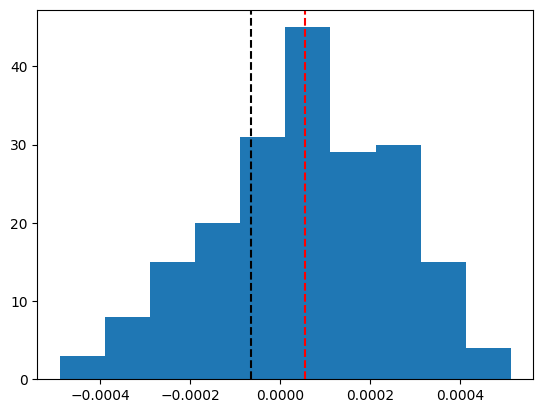

In [112]:
plt.hist(mb)
plt.axvline(m, c='k', ls='--')
# plt.axvline(mjs[-1].mean(), c='bx', ls='--')
plt.axvline(mb.mean(), c='r', ls='--')

In [113]:
mb.mean(), mb.std()

(Array(5.58996729e-05, dtype=float64), Array(0.00019884, dtype=float64))

# Look at mean of posteriors on shear

In [114]:
gpj.shape, gpb.shape

((100, 1000, 2), (200, 1000, 2))

In [117]:
np.sqrt(gpj[...,0].mean(1).var()  * (99))

np.float64(0.0006007032247028022)

In [118]:
gpb[...,0].mean(1).std()

Array(0.00061257, dtype=float64)

In [119]:
# they agree!